### Rubric:

- A statement of the problem you are investigating
- Why is this problem relevant? Or, what inspired you to investigate this problem?
- Where did you get the data from?
- Description of the data
- Exploratory data analysis
- What (if any) analyses have already been performed on this data (or another similar dataset)?
    - You should provide references to this
- What types of analyses did you perform?
- How do you interpret the results from these analyses?
- What are some potential limitations and shortcoming of your analyses?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

In [56]:
hbo = pd.read_csv('hbo_clean.csv')
netflix = pd.read_csv('netflix_clean.csv')
amazon = pd.read_csv('amazon_clean.csv')
paramount = pd.read_csv('paramount_clean.csv')
apple = pd.read_csv('apple_clean.csv')

# Names

* Mia Jerphagnon
* Ari Juljulian
* Nicholas Jumaoas

# Abstract

At a time when TV entertainment is almost exclusively dominated by streaming platforms, consumers rely on companies like Netflix, Amazon Prime, and Hulu to watch their favorite shows. However, online discourse has emerged that suggests streaming has led to many shows being canceled prematurely, even if the ratings are high. This accusation is particularly aimed at Netflix for canceling well-received shows such as Julie and the Phantoms and Shadow and Bone. In addition to the distress caused by canceled shows—or shows that are only greenlit for a couple seasons despite potential—for consumers, the trend of short lifespans also deeply impacts those employed in the entertainment industry. Cast, crew, and everyone else involved in a show are unable to have long-term and reliable unemployment. This impact is especially important within the context of the recent SAG-AFTRA strike of 2023.

Netflix’s actions have raised concerns over its business and content strategy, leading many to debate whether they should cancel their Netflix subscriptions. Thus, our project aims to analyze the longevity of Netflix shows in comparison to other shows, as well as in relation to other factors such as ratings, genre, and more.

# Research Question 

...

## Background and Prior Work

If we have more stuff to say I guess but not part of the abstract

Maybe, to fulfill the rubric: 
- Why is this problem relevant? Or, what inspired you to investigate this problem?
- What (if any) analyses have already been performed on this data (or another similar dataset)?
    - You should provide references to this


# Hypothesis

We are kind of doing a lot of tests, so I don't know if we should specify one hypothesis or multiple, or even have this section at all.

# Data

## Data Overview

For the purposes of this project, we will be using a collection of datasets compiled by Kaggle user Diego Enrique, constructed using data from site JustWatch in March of 2023. These datasets contain basic metadata for shows on streaming platforms, with separate, standardized datasets for Netflix, Amazon Prime, HBO Max, Paramount, and Apple TV. 

This breadth of coverage was one of our main motivations for choosing this collection, since it allows for multiple comparisons under similar conditions. Other points of note include its recency, which is especially relevant considering that Netflix’s chronic cancellations are a somewhat newer phenomenon, as well as its specific inclusion of the number of seasons and release year of each show, which were not present on several of the alternatives.


## Pre-Processing

Although the original datasets are conveniently already fairly clean and standardized, we performed some additional pre-processing tasks in order to adapt the data to best suit our purposes. Given that we are primarily concerned with show cancellations, we filtered out movie entries from the datasets, discarding irrelevant information in order to streamline both the testing process and code runtime. For the same reason, we also pruned unnecessary features such as listing description, age certification, and production countries, since they are not pertinent to our analysis. Some of our desired attributes required further transformation in order to be processed correctly or efficiently. After conducting this data wrangling, we arrived at the set of attributes detailed in Table 1.

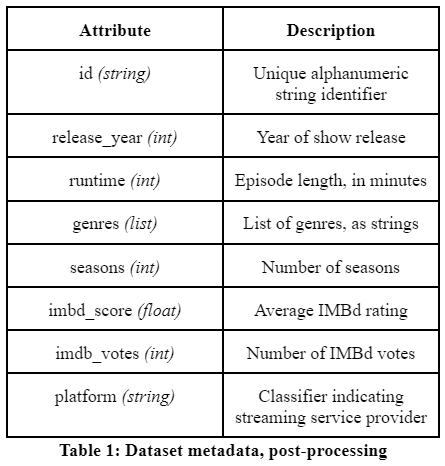

In [ ]:
## Main Pre-Processing Tasks

# reading in raw data
netflix_df = pd.read_csv('raw_data/netflix.csv')
amazon_df = pd.read_csv('raw_data/amazon.csv')
max_df = pd.read_csv('raw_data/max.csv')
apple_df = pd.read_csv('raw_data/apple.csv')
paramount_df = pd.read_csv('raw_data/paramount.csv')

dfs = {
    'netflix': netflix_df,
    'amazon': amazon_df,
    'max': max_df,
    'apple': apple_df,
    'paramount': paramount_df
}

for name, df in dfs.items():
    copy = df.copy()

    # filters out movies
    copy = copy[copy['type'] == 'SHOW']

    # determines which features are retained
    copy = copy[['id',
                 'release_year', 
                 'runtime', 
                 'genres', 
                 'seasons', 
                 'imdb_score', 
                 'imdb_votes']]
    
    # switches out NaN values in imdb_score/votes
    copy = copy.replace({np.nan: 0})

    # type change for ease of analysis
    copy[['seasons', 'imdb_votes']] = copy[['seasons', 'imdb_votes']].astype(int)
    
    # adds classification tag indicating streaming service of origin
    copy['platform'] = name
    
    copy.to_csv(f"{name}_clean.csv", index = False)

In [ ]:
## Generating Cleaned Datasets

# individual streaming services
netflix_clean = pd.read_csv('netflix_clean.csv')
amazon_clean = pd.read_csv('amazon_clean.csv')
max_clean = pd.read_csv('max_clean.csv')
apple_clean = pd.read_csv('apple_clean.csv')
paramount_clean = pd.read_csv('paramount_clean.csv')

# combined (for comparison between services)
data = pd.concat([netflix_clean, amazon_clean, max_clean, apple_clean, paramount_clean], ignore_index = True)
data.to_csv('all_clean.csv', index = False)

# maps platforms for convenience
platforms = {
    'Netflix': netflix,
    'HBO Max': hbo,
    'Amazon': amazon,
    'Apple': apple,
    'Paramount': paramount
}

For convenience, an excerpt of the dataset is also provided. Scores of 0 in the ‘imdb_score’ and ‘imdb_votes’ columns were converted from their original NaN values to indicate that the corresponding show did not have a listing on IMDb;  no show in the dataset had an initial value of 0 for either of these features.

In [ ]:
## Generates excerpt of processed data

data.head()

,platform,id,release_year,runtime,genres,seasons,imdb_score,imdb_votes,duration
0,Netflix,ts300399,1945,51,['documentation'],1,0.0,0,51
1,Netflix,ts22164,1969,30,"['comedy', 'european']",4,8.8,75654,120
2,Netflix,ts45948,1972,43,['comedy'],1,8.1,2199,43
3,Netflix,ts20681,1989,24,['comedy'],9,8.9,326487,216
4,Netflix,ts21715,1984,10,"['animation', 'family', 'fantasy', 'music', 'd...",24,6.5,5528,240


# Exploratory Data Analysis

## Visualizing Number of Seasons vs Release Date

As we can see, shows released more recently have seen a signifcant reduction in number of seasons. 

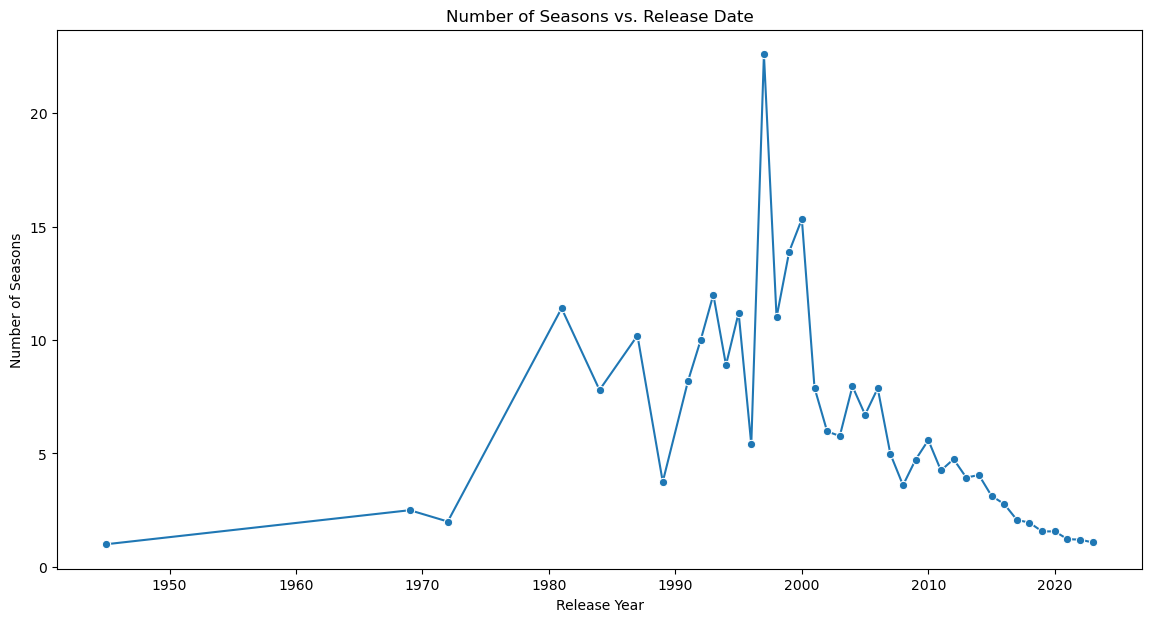

In [7]:
netflix['seasons_smoothed'] = netflix['seasons'].rolling(window=5, min_periods=1).mean()

plt.figure(figsize=(14, 7))
sns.lineplot(data=netflix, x='release_year', y='seasons_smoothed', marker='o', ci=None)
plt.title('Number of Seasons vs. Release Date')
plt.xlabel('Release Year')
plt.ylabel('Number of Seasons')
plt.show()

## Visualizing Number of Seasons and IMDb Score

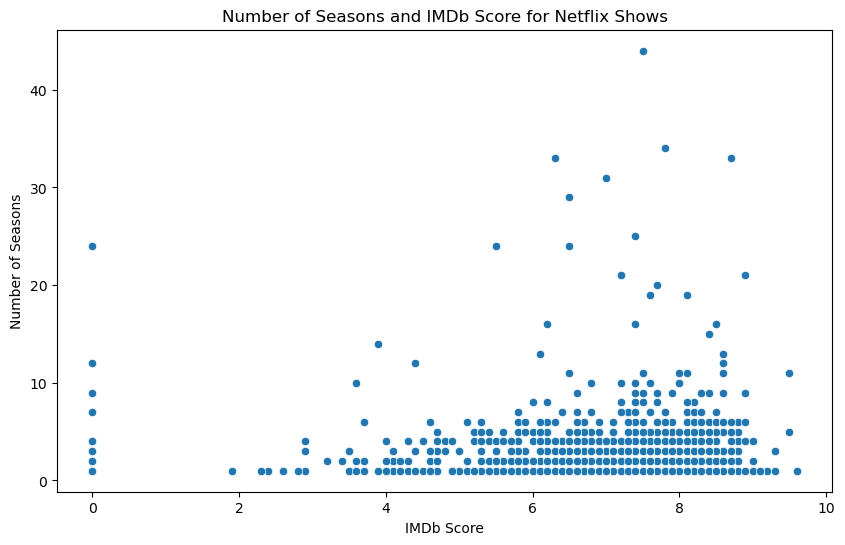

In [8]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=netflix, x='imdb_score', y='seasons')
plt.title('Number of Seasons and IMDb Score for Netflix Shows')
plt.xlabel('IMDb Score')
plt.ylabel('Number of Seasons')
plt.show()

## Permutation Test 1: Do higher-rated shows have more seasons than lower-rated shows? 

#### Hypotheses

$H_0$: There is no difference in the number of seasons between higher-rated and lower-rated shows. 
$$\mu_H - \mu_L = 0$$

$H_a$: Higher-rated shows have more seasons than lower-rated shows. 
$$\mu_H - \mu_L > 0$$

#### Test Statistic

Difference in means

#### Significance Value 

$\alpha$ = 0.05

In [39]:
# Helper function to calculate the difference in means
def diff_means(df, group, col='seasons'):
    
    # Create a table with the means for each group 
    means_df = df.groupby(group)['seasons'].mean()

    # Calculate the difference in means
    return means_df.iloc[1] - means_df.iloc[0]


def perm_test_1(platform_data, platform_name):
    
    # Add new boolean column indicating whether a show has a high rating (>7) or a low rating (<=7)
    df = platform_data.copy()
    df['is_high_rating'] = df['imdb_score'] > 7

    # Calculate the difference in means
    observed_stat = diff_means(df, 'is_high_rating')

    # Run 10,000 simulations
    n = 10000
    test_stats = []
    
    for i in range(n):
        shuffled_ratings = np.random.permutation(df['is_high_rating'])
        shuffled_df = df.assign(is_high_rating = shuffled_ratings)
        test_stats.append(diff_means(shuffled_df, 'is_high_rating'))

    p_value = np.sum(test_stats >= observed_stat) / n

    print(f'{platform_name} results')
    print(f'Observed test statistic: {observed_stat}')
    print(f'P-value: {p_value}\n')

for platform_name, platform_data in platforms.items():
    perm_test_1(platform_data, platform_name)

Netflix results
Observed test statistic: 0.5950883583707138
P-value: 0.0

HBO results
Observed test statistic: 1.4384394341290894
P-value: 0.0

Amazon results
Observed test statistic: 0.6077180096926642
P-value: 0.0004

Apple results
Observed test statistic: 0.31404644080700406
P-value: 0.0424

Paramount results
Observed test statistic: 0.14604515923856276
P-value: 0.363



Paramount's p-value is larger than the significance level of 0.05, so, for Paramount, we fail to reject the null hypothesis. There is not statistically significant evidence suggesting that higher-rated shows have more seasons than lower-rated shows. 

However, for Netflix, HBO, Amazon, and Apple, the p-values are smaller than the significance level of 0.05, so, for these streaming services, we reject the null hypothesis. There is statistically significant evidence suggesting that higher-rated shows have more seasons than lower-rated shows. 

It is important to note that Paramount and Apple had a much higher p-value than the other platforms, so if we had chosen a signifance level of 0.04, for example, we would have failed to reject the null hypothesis for Apple as well. 

## Permutation Test 2: Do shows of different genres have different season lengths?

For example, let's take a look shows within the Drama genre.

In [10]:
data['is_drama'] = data['genres'].apply(lambda genres: 'drama' in genres)

avg_seasons_drama = data[data['is_drama']]['seasons'].mean()
avg_seasons_non_drama = data[~data['is_drama']]['seasons'].mean()

In [11]:
print(f'Average number of seasons for drama shows: {np.round(avg_seasons_drama, 2)}')
print(f'Average number of seasons for non-drama shows: {np.round(avg_seasons_non_drama, 2)}')

Average number of seasons for drama shows: 2.4
Average number of seasons for non-drama shows: 2.79


At first glance, it seems like drama shows run for fewer seasons that non-drama shows.

Let's a run a permutation test to further investigate.

#### Hypotheses

$H_0$: ...

$H_a$:

#### Test Statistic

...

#### Significance Value 

$\alpha$ = 0.05

In [63]:
def perm_test_2(platform_data, platform_name):
    
    df = platform_data.copy()

    df['is_drama'] = df['genres'].apply(lambda genres: 'drama' in genres)

    # Calculate the difference in means
    observed_stat = diff_means(df, 'is_drama')

    # Run 10,000 simulations
    n = 10000
    test_stats = []
    
    for i in range(n):
        shuffled_ratings = np.random.permutation(df['is_drama'])
        shuffled_df = df.assign(is_high_rating = shuffled_ratings)
        test_stats.append(diff_means(shuffled_df, 'is_drama'))

    p_value = np.sum(test_stats >= observed_stat) / n

    print(f'{platform_name} results')
    print(f'Observed test statistic: {observed_stat}')
    print(f'P-value: {p_value}\n')

for platform_name, platform_data in platforms.items():
    perm_test_2(platform_data, platform_name)

Netflix results
Observed test statistic: -0.2681166624489353
P-value: 1.0

HBO Max results
Observed test statistic: -0.38415392960847505
P-value: 1.0

Amazon results
Observed test statistic: -0.6405737704918031
P-value: 1.0

Apple results
Observed test statistic: -0.001046389954656446
P-value: 1.0

Paramount results
Observed test statistic: 1.6638592095035905
P-value: 1.0



## Correlation Matrix: Netflix vs. Non-Netflix Platforms

In [13]:
df_without_netflix = data[data['platform'] != 'Netflix'] # retaining all platforms except for Netflix

In [14]:
corr_matrix_all = df_without_netflix[['seasons', 'imdb_score', 'runtime', 'release_year']].corr()
print(corr_matrix_all)

               seasons  imdb_score   runtime  release_year
seasons       1.000000    0.117377 -0.081997     -0.458402
imdb_score    0.117377    1.000000  0.070391     -0.155998
runtime      -0.081997    0.070391  1.000000      0.127239
release_year -0.458402   -0.155998  0.127239      1.000000


As we can see, release_year and seasons has a moderate negative association for all platforms.

In [15]:
corr_matrix_netflix = netflix[['seasons', 'imdb_score', 'runtime', 'release_year']].corr()
print(corr_matrix_netflix)

               seasons  imdb_score   runtime  release_year
seasons       1.000000    0.101226 -0.126456     -0.517217
imdb_score    0.101226    1.000000  0.072713     -0.103113
runtime      -0.126456    0.072713  1.000000      0.143329
release_year -0.517217   -0.103113  0.143329      1.000000


The negative assocation between `release_year` and `seasons` is stronger for the Netflix data, but there is not a significant difference.

## Permutation Tests 3-4: Do Netflix shows have fewer seasons than Non-Netflix shows?

In order to investigate this question, we will run two permutation tests, one using total variation distance, and the other using difference in means. Total variation distance will help us understand how different the distributions are, while the difference in means will help us understand the direction of the difference. A positive difference in means indicates Netflix more seasons, while a negative difference in means indicates Netflix has fewer seasons. 

### Permutation Test 3
#### Hypotheses

$H_0$: There is no difference in the distribution of the number of seasons between Netflix shows and non-Netflix shows. Any observed difference in the distribution of the number of seasons is due to random chance.

$H_a$: There is a difference in the distribution of the number of seasons between Netflix TV shows and non-Netflix TV shows. The observed difference in the distribution of the number of seasons is not due to random chance.

#### Test Statistic

Total variation distance 

#### Significance Value 

$\alpha$ = 0.05

### Permutation Test 4
#### Hypotheses

$H_0$: There is no difference in the number of seasons between Netflix and non-Netflix shows. 
$$\mu_{Netflix} - \mu_{other} = 0$$

$H_a$: Netflix shows have fewer seasons than non-Netflix shows. 
$$\mu_{Netflix} - \mu_{other} < 0$$

#### Test Statistic

Difference in means

#### Significance Value 

$\alpha$ = 0.05


In [42]:
# Add new boolean column indicating whether a show is from Netflix or another platform
df = data.copy()
df['is_netflix'] = df['platform'] == 'Netflix'

# Calculate the observed difference in means
observed_mean = diff_means(df, 'is_netflix')

# Helper function for calculating TVD

def calc_tvd(df, group, col='seasons'):
    group1 = df[df[group]==True][col]
    group2 = df[df[group]==False][col]
    proportions1, _ = np.histogram(group1, bins=bin_edges, density=True)
    proportions2, _ = np.histogram(group2, bins=bin_edges, density=True)
    return 0.5 * np.sum(np.abs(proportions1 - proportions2))

# Make sure bin edges are consistent throughout groups and permutations
bin_edges = np.histogram_bin_edges(data['seasons'], bins='auto')

# Calculate the observed TVD
observed_tvd = calc_tvd(df, 'is_netflix')

# Run 10,000 simulations
n = 10000
tvds = []
means = []

for i in range(n):
    shuffled_netflix = np.random.permutation(df['is_netflix'])
    shuffled_df = df.assign(is_netflix = shuffled_netflix)

    # Find TVD
    tvd = calc_tvd(shuffled_df, 'is_netflix')
    tvds.append(tvd)
    
    # Find difference in means
    mean = diff_means(shuffled_df, 'is_netflix')
    means.append(mean)

tvd_p_value = np.sum(tvds >= observed_tvd) / n
mean_p_value = np.sum(means >= observed_mean) / n

print(f'TVD results')
print(f'Observed TVD: {observed_tvd}')
print(f'P-value: {tvd_p_value}\n\n')
print(f'Difference in means results')
print(f'Observed diff. in means: {observed_mean}')
print(f'P-value: {mean_p_value}\n\n')

TVD results
Observed TVD: 0.6109741937522718
P-value: 0.0


Difference in means results
Observed diff. in means: -0.9075832293993522
P-value: 1.0




## Netflix Heatmap

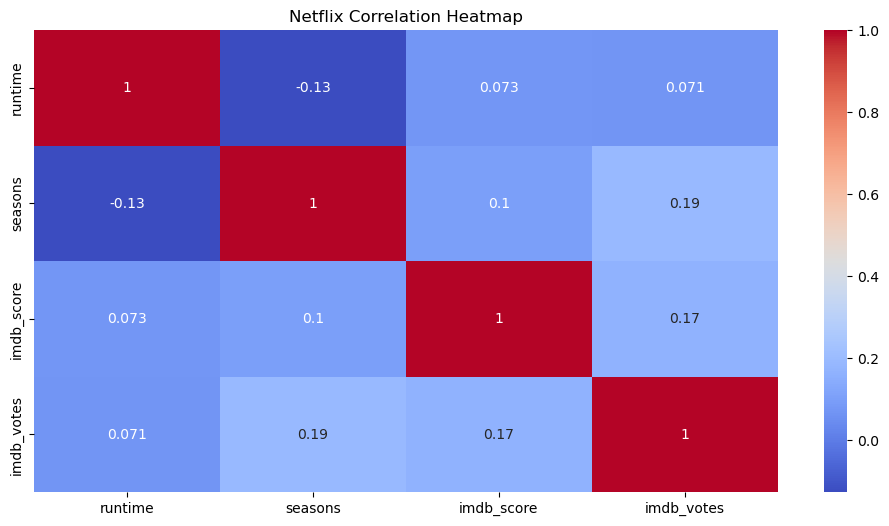

In [16]:
plt.figure(figsize=(12, 6))
corr_matrix = netflix[['runtime', 'seasons', 'imdb_score', 'imdb_votes']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Netflix Correlation Heatmap')
plt.show()

In [17]:
data['is_drama'] = data['genres'].apply(lambda genres: 'drama' in genres)

avg_seasons_drama = data[data['is_drama']]['seasons'].mean()
avg_seasons_non_drama = data[~data['is_drama']]['seasons'].mean()

In [18]:
print(f'Average number of seasons for drama shows: {np.round(avg_seasons_drama, 2)}')
print(f'Average number of seasons for non-drama shows: {np.round(avg_seasons_non_drama, 2)}')

Average number of seasons for drama shows: 2.4
Average number of seasons for non-drama shows: 2.79


We hypothesized that drama shows would, on average, have more seasons as it takes a longer time for the plot and character arcs to develop. However, the opposite is proven, as non-drama shows, on average, have more seasons.

In [198]:
from scipy.stats import ttest_ind

drama_seasons = data[data['is_drama']]['seasons']
non_drama_seasons = data[~data['is_drama']]['seasons']

t_stat, p_value = ttest_ind(drama_seasons, non_drama_seasons)

print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

T-statistic: -3.8234832934074454
P-value: 0.00013310411269057816


We conducted a t-test to confirm that the difference between average seasons for non-drama and drama shows is statistically signficant. 

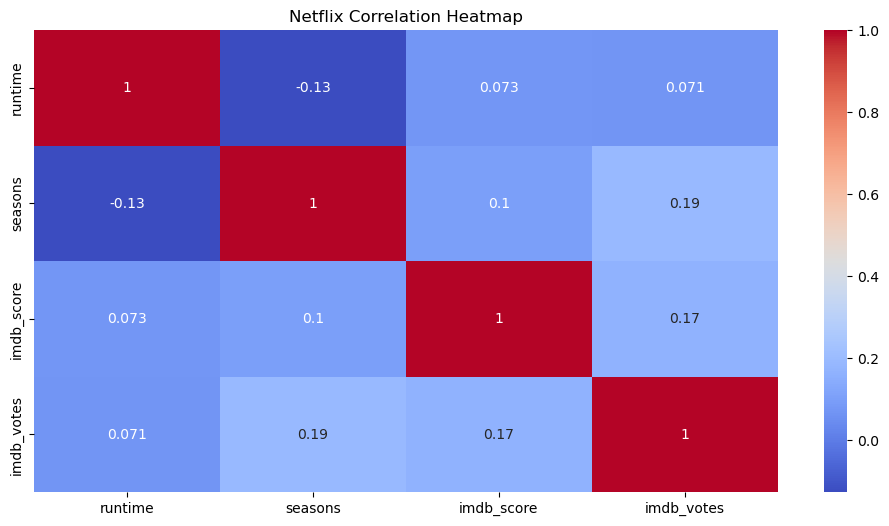

In [26]:
plt.figure(figsize=(12, 6))
corr_matrix = netflix[['runtime', 'seasons', 'imdb_score', 'imdb_votes']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Netflix Correlation Heatmap')
plt.show()